In [0]:
from keras import Model
from keras import layers
from matplotlib import pyplot
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

def resnet_block(x, filters, stride = (1,1), match = False):

  shortcut = x
  x = layers.Conv2D(filters, (1,1), strides = stride)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters, (3,3), padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters*4, (1,1))(x)
  x = layers.BatchNormalization()(x)

  if (match == True):#To match size of shortcut to the output if needed
    shortcut = layers.Conv2D(filters*4, (1,1), strides = stride)(shortcut)
  
  x = layers.add([x,shortcut])
  x = layers.ReLU()(x)

  return x

In [0]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar100.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [0]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [4]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)

169009152/169001437 [==============================] - 2s 0us/step


In [5]:
inputs = layers.Input(shape = (32,32,3))
x = layers.Conv2D(64, kernel_size=(3,3), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)


x = resnet_block(x, 64, match = True)

for _ in range(2):
  x = resnet_block(x,64)

#double the number of filters
x = resnet_block(x, 128, stride = (2,2), match = True)

for _ in range(3):
  x = resnet_block(x,128)

#double the number of filters
x = resnet_block(x, 256, stride = (2,2), match = True)

for _ in range(5):
  x = resnet_block(x,256)

x = resnet_block(x, 512, stride = (2,2), match = True)

for _ in range ( 2 ):
  x = resnet_block(x, 512)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(100, activation = 'softmax')(x)

model = Model(inputs,outputs )
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])


In [7]:
from keras.callbacks import ModelCheckpoint
filepath='/content/sample_data/best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=callbacks_list)
model.save('cifar model')


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 216s 4ms/step - loss: 4.6420 - acc: 0.0436 - val_loss: 5.2312 - val_acc: 0.0678

Epoch 00001: val_acc improved from -inf to 0.06780, saving model to /content/sample_data/best.hdf5
Epoch 2/30
50000/50000 [==============================] - 204s 4ms/step - loss: 4.1078 - acc: 0.0977 - val_loss: 3.9596 - val_acc: 0.1062

Epoch 00002: val_acc improved from 0.06780 to 0.10620, saving model to /content/sample_data/best.hdf5
Epoch 3/30
50000/50000 [==============================] - 204s 4ms/step - loss: 3.5315 - acc: 0.1583 - val_loss: 3.3903 - val_acc: 0.1820

Epoch 00003: val_acc improved from 0.10620 to 0.18200, saving model to /content/sample_data/best.hdf5
Epoch 4/30
50000/50000 [==============================] - 203s 4ms/step - loss: 3.2766 - acc: 0.2016 - val_loss: 3.2600 - val_acc: 0.2056

Epoch 00004: val_acc improved from 0.18200 to 0.20560, saving model to /content/sample_data

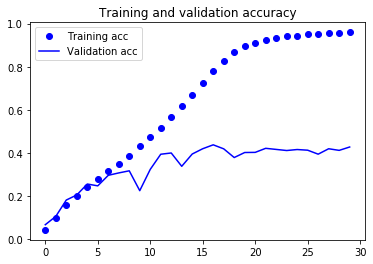

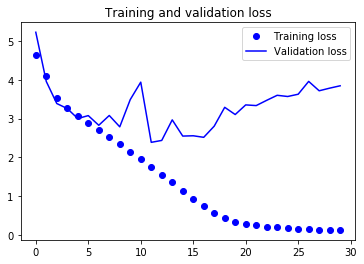

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
import numpy as np
import sys
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=sys.maxsize)

Y_pred = model.predict(testX)
y_pred1 = np.argmax(Y_pred, axis=1)
testY1 = np.argmax(testY, axis=1)
print(testY1)
print(y_pred1)

In [0]:

plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')

classes = []
for i in range(0,99):
  classes.append(i)

plot_confusion_matrix(confusion_matrix(y_pred1,testY1),classes)
plt.savefig('plt.png')

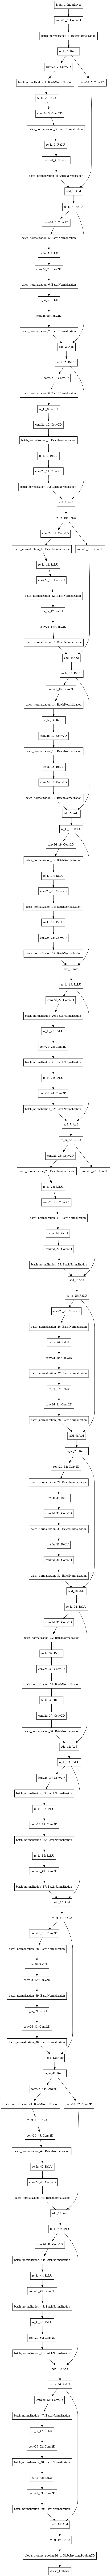

In [55]:
plot_model(model,'model.png')